<h1 align="center" style="margin-bottom: 20px;">Machine Learning 2024-25</h1>
<h3 align="center" style="margin-top: 20px; margin-bottom: 20px;">To Grant or Not to Grant: Deciding on Compensation Benefits</h3>
<h5 align="center" style="margin-top: 20px; margin-bottom: 0px;">Notebook 2: Cross-Validation and Deployment</h5>

### Group 38 - Members:
- Ana Marta Azinheira  - 20240496@novaims.unl.pt
- Braulio Damba - 20240007@novaims.unl.pt
- Catarina Ribeirinha - 20240507@novaims.unl.pt
- Marco Galão  - r20201545@novaims.unl.pt
- Rodrigo Sardinha - 20211627@novaims.unl.pt

# Table of Contents

* [1. Imports](#imports)
  * [1.1. Import Libraries](#import_libraries)
  * [1.2. Imports Datasets](#import_datasets)

* [2. Analysis Before Cross-Validation](#analysis_before_cv)
  * [2.1. Outliers (Only Analysis)](#outliers)
    * [2.1.1. Metric and Non-metric Features](#defining_features)
    * [2.1.2. Histograms and Boxplots](#visualizations)
    * [2.1.3. Filtering](#filtering)
      * [2.1.3.1. IQR Method](#iqr_method)
      * [2.1.3.2. Manual](#manual)
      * [2.1.3.3. Winsorizing](#winsorizing)
    * [3.5.4. Shape Status](#outliers_shape_status)

  * [2.2. Missing Values Imputation (Only Analysis)](#mv_imputation)

* [3. Cross-Validation](#cross_validation)
  * [3.1 Define Auxiliary Functions](#aux_functions)
  * [3.2 Define Cross-Validation Function](#cv_function)
  * [3.3 Define Function to Show Cross-Validation Results](#show_results_function)
  * [3.4 Apply Cross-Validation](#apply_cv)

* [4. Deployment](#deployment)

# 1. Imports <a id="imports"></a>

## 1.1. Import the Libraries <a class="anchor" id="import_libraries"></a>


In [220]:
# General Libraries
import pandas as pd
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning and Data Preprocessing
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder

# Feature Selection
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Machine Learning Models and Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier # pip install xgboost scikit-learn
from sklearn.svm import SVC

# Model Evaluation
from sklearn.metrics import f1_score
import time

# Visualization Settings
%config InlineBackend.figure_format = 'retina'
sns.set()

# Omit Warnings
import warnings
warnings.filterwarnings("ignore")

## 1.2. Import the Datasets <a class="anchor" id="import_datasets"></a>

In [221]:
# Define date columns to parse
date_cols = ["Accident Date", "Assembly Date", "C-2 Date", "C-3 Date", "First Hearing Date"]

In [222]:
df = pd.read_csv('group_38_df_before_cv.csv', sep=',', parse_dates=date_cols)
df.head()

,Claim Identifier,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,C-2 Date,C-3 Date,Carrier Name,...,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Male
0,5393875,2019-12-30,31,0.0,2020-01-01,0,0.00,2019-12-31,NaT,new hampshire insurance company,...,RETAIL TRADE,I,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662.0,1.0
1,5393091,2019-08-30,46,0.0,2020-01-01,1,1745.93,2020-01-01,2020-01-01,zurich american insurance company,...,CONSTRUCTION,I,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569.0,0.0
2,5393889,2019-12-06,40,0.0,2020-01-01,0,1434.80,2020-01-01,NaT,indemnity insurance company of,...,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,II,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589.0,1.0
3,5393887,2019-12-30,61,0.0,2020-01-01,0,NaN,2019-12-31,NaT,state insurance fund,...,HEALTH CARE AND SOCIAL ASSISTANCE,II,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603.0,1.0
4,5393863,2019-12-26,67,0.0,2020-01-01,0,0.00,2019-12-31,NaT,indemnity insurance of n america,...,RETAIL TRADE,IV,31.0,"FALL, SLIP OR TRIP, NOC",10.0,CONTUSION,38.0,SHOULDER(S),11772.0,1.0


In [223]:
df_test = pd.read_csv('group_38_df_test_before_cv.csv', sep=',', parse_dates=date_cols)
df_test.head()

,Claim Identifier,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,C-2 Date,C-3 Date,Carrier Name,...,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Male
0,6165911,2022-12-24,19,0.0,2023-01-02,0,NaN,2023-01-02,NaT,indemnity insurance company of,...,TRANSPORTATION AND WAREHOUSING,IV,31.0,"FALL, SLIP OR TRIP, NOC",10.0,CONTUSION,54.0,LOWER LEG,10466.0,1.0
1,6166141,2022-11-20,19,0.0,2023-01-02,0,NaN,2023-01-02,NaT,a i u insurance company,...,RETAIL TRADE,IV,75.0,FALLING OR FLYING OBJECT,10.0,CONTUSION,10.0,MULTIPLE HEAD INJURY,11691.0,0.0
2,6165907,2022-12-26,59,0.0,2023-01-02,0,0.0,2022-12-31,NaT,amguard insurance company,...,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,III,68.0,STATIONARY OBJECT,49.0,SPRAIN OR TEAR,62.0,BUTTOCKS,10604.0,0.0
3,6166047,2022-12-28,55,0.0,2023-01-02,0,0.0,2023-01-02,NaT,indemnity insurance of n america,...,TRANSPORTATION AND WAREHOUSING,IV,25.0,FROM DIFFERENT LEVEL (ELEVATION),10.0,CONTUSION,53.0,KNEE,11411.0,0.0
4,6166102,2022-12-20,25,0.0,2023-01-02,0,0.0,2022-12-31,NaT,new hampshire insurance company,...,MANAGEMENT OF COMPANIES AND ENTERPRISES,IV,79.0,OBJECT BEING LIFTED OR HANDLED,40.0,LACERATION,37.0,THUMB,11212.0,1.0


In [224]:
df_sample_submission = pd.read_csv('../data/sample_submission.csv', sep=',')
df_sample_submission.head()

,Claim Identifier,Claim Injury Type
0,6165911,2. NON-COMP
1,6166141,2. NON-COMP
2,6165907,2. NON-COMP
3,6166047,2. NON-COMP
4,6166102,2. NON-COMP


# 2. Analysis Before Cross-Validation <a id="analysis_before_cv"></a>

## 2.1. Outliers (Only Analysis) <a id="outliers"></a>

**Note:**

Before performing cross-validation, we will evaluate different outlier removal approaches. Although this is not entirely correct — as it involves assessing both the training and validation data together during outlier evaluation — it is a more practical method for determining the best approach and thresholds for outlier removal.

By evaluating outliers outside the cross-validation function, we can efficiently compare multiple strategies and their impact on the data. Once the optimal method and values are identified, we will apply them consistently throughout the modeling process.

### 2.1.1 Metric and Non-metric Features <a id="defining_features"></a>

In [225]:
# Define metric (numerical) features for both train and validation datasets
metric_features = df.select_dtypes(include=['number']).columns.tolist()
non_metric_features = df.select_dtypes(exclude=['number']).columns.tolist()

In [226]:
metric_features

['Claim Identifier',
 'Age at Injury',
 'Alternative Dispute Resolution',
 'Attorney/Representative',
 'Average Weekly Wage',
 'COVID-19 Indicator',
 'Industry Code',
 'WCIO Cause of Injury Code',
 'WCIO Nature of Injury Code',
 'WCIO Part Of Body Code',
 'Zip Code',
 'Male']

In [227]:
non_metric_features

['Accident Date',
 'Assembly Date',
 'C-2 Date',
 'C-3 Date',
 'Carrier Name',
 'Carrier Type',
 'Claim Injury Type',
 'County of Injury',
 'District Name',
 'First Hearing Date',
 'Industry Code Description',
 'Medical Fee Region',
 'WCIO Cause of Injury Description',
 'WCIO Nature of Injury Description',
 'WCIO Part Of Body Description']

### 2.1.2 Histograms and Boxplots <a id="visualizations"></a>

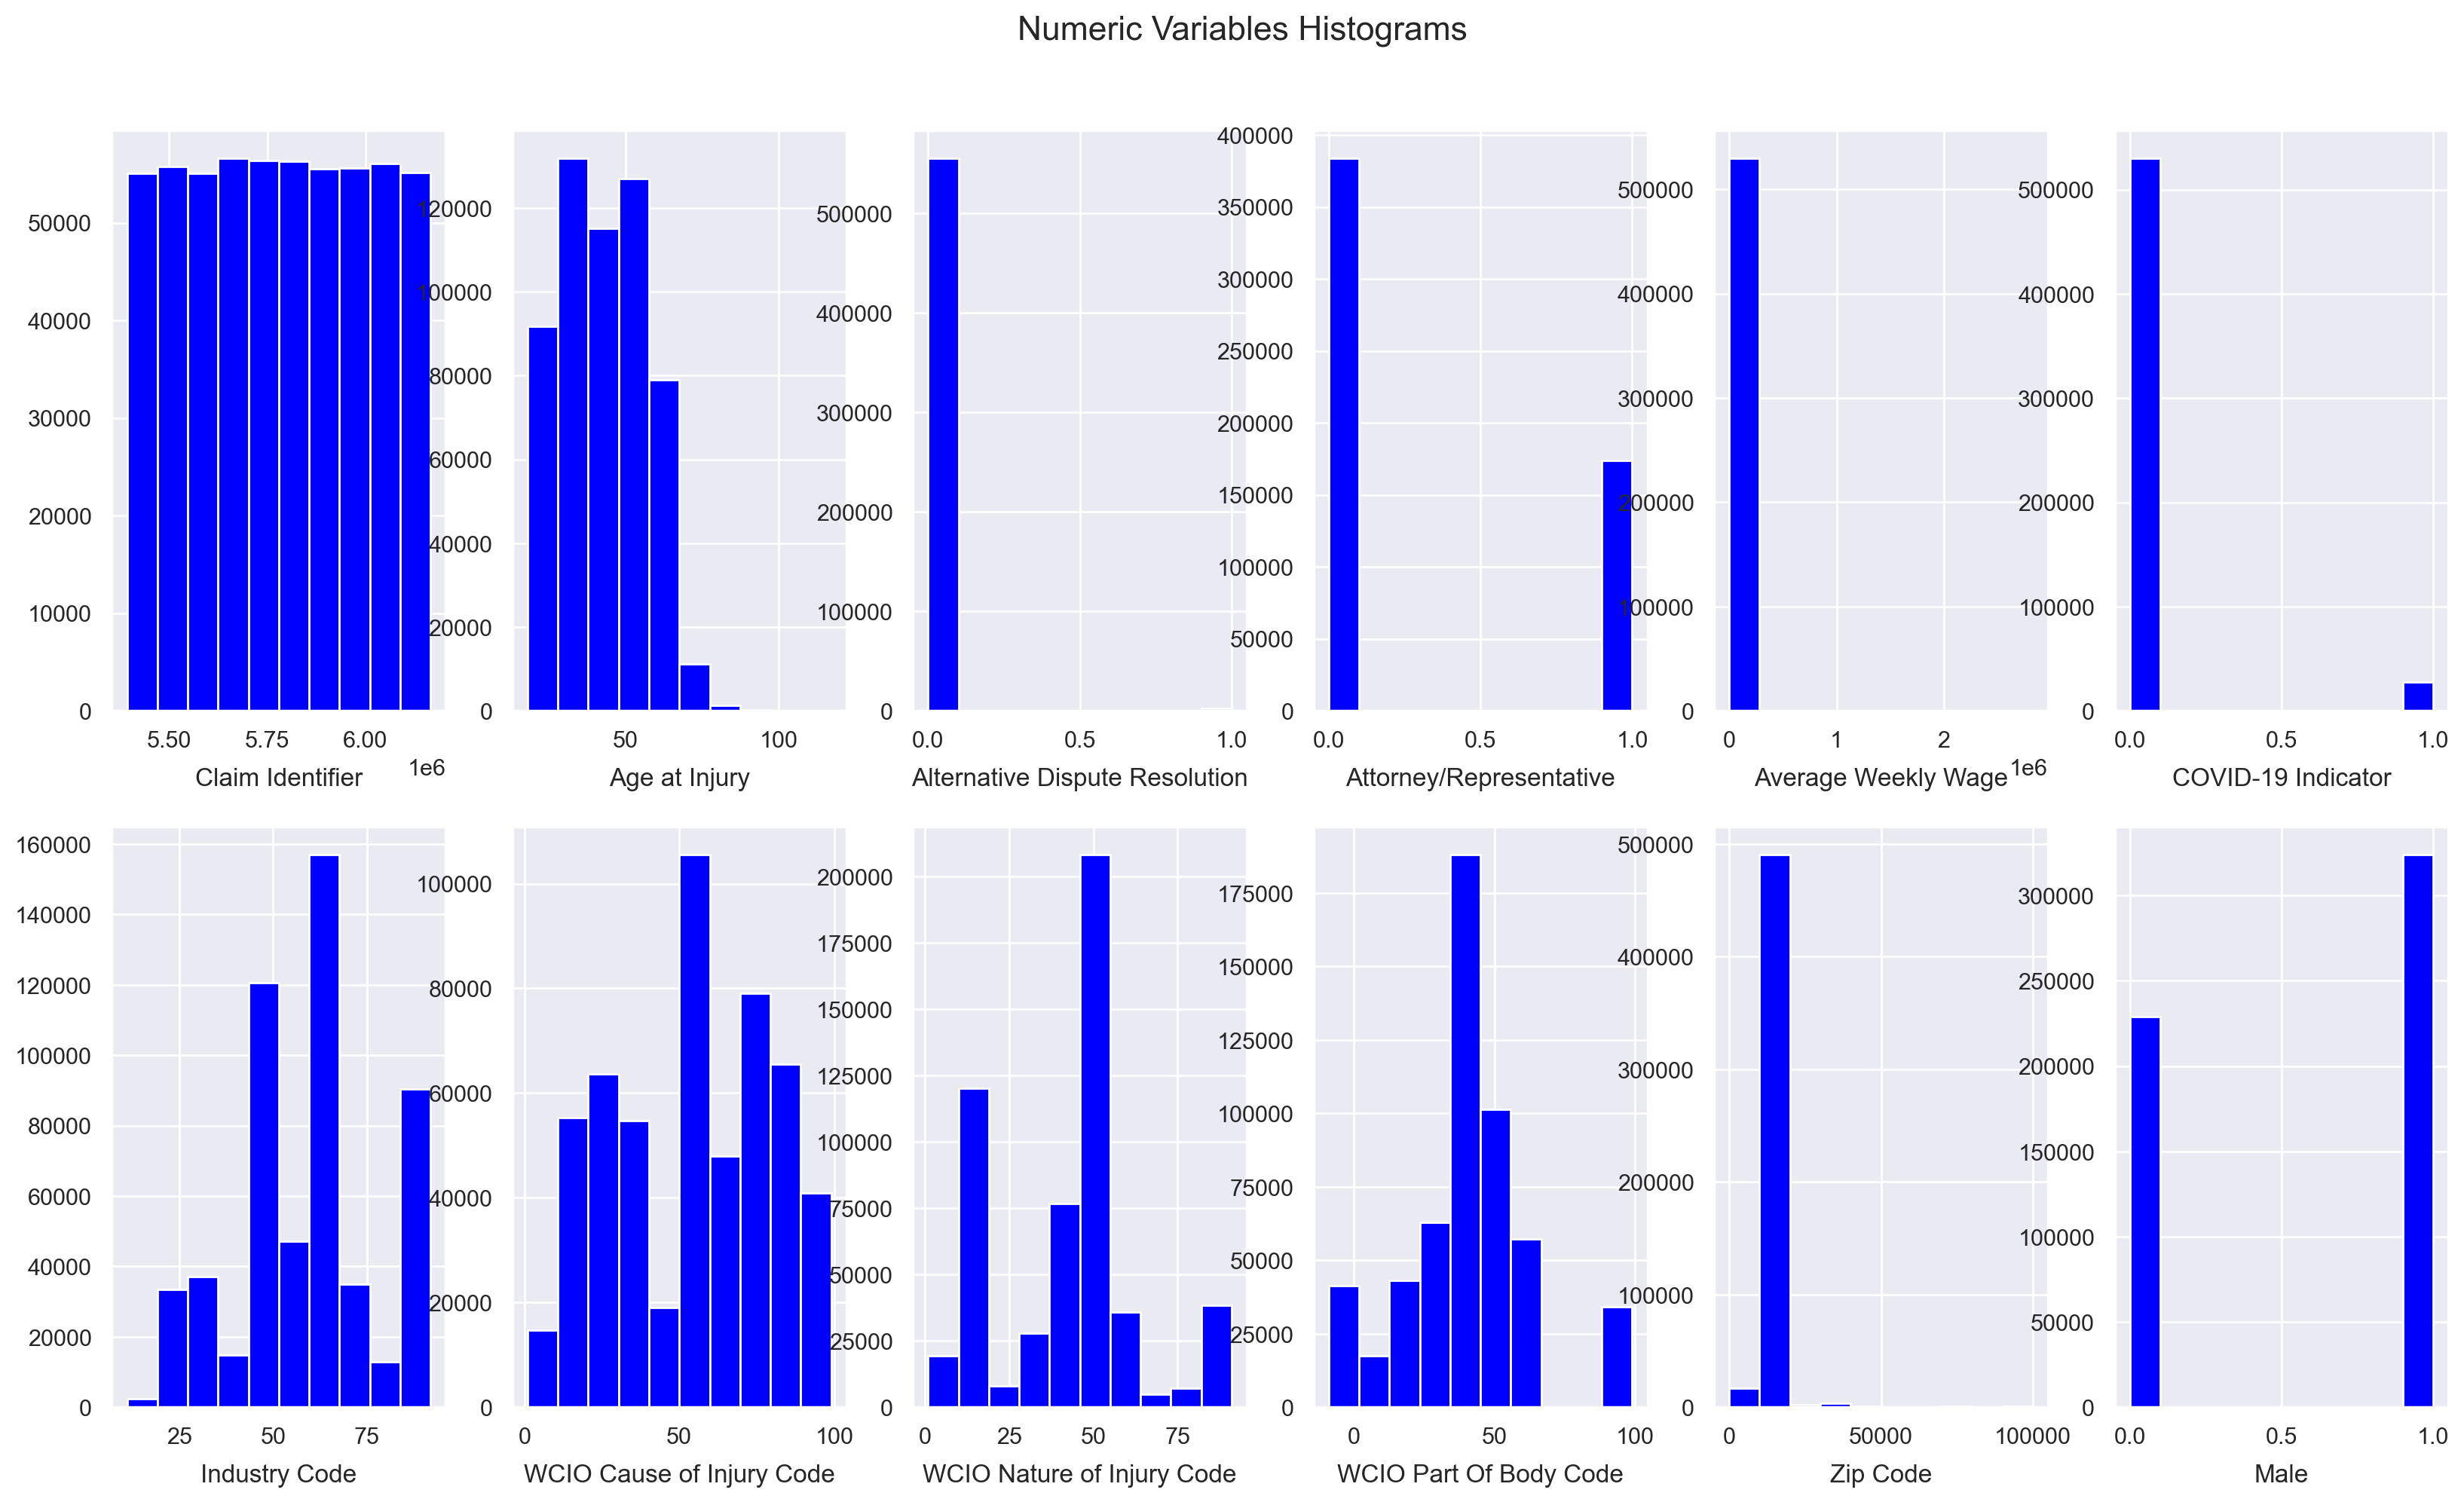

In [228]:
# Plot all numeric features (histograms)
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot histograms for df
for ax, feat in zip(axes.flatten(), metric_features):
    ax.hist(df[feat], bins=10, color='blue')
    ax.set_title(feat, y=-0.15)

# Remove empty axes (if there are any)
for ax in axes.flatten()[len(metric_features):]:
    fig.delaxes(ax)

plt.suptitle('Numeric Variables Histograms', fontsize=16, y=0.95)
plt.show()

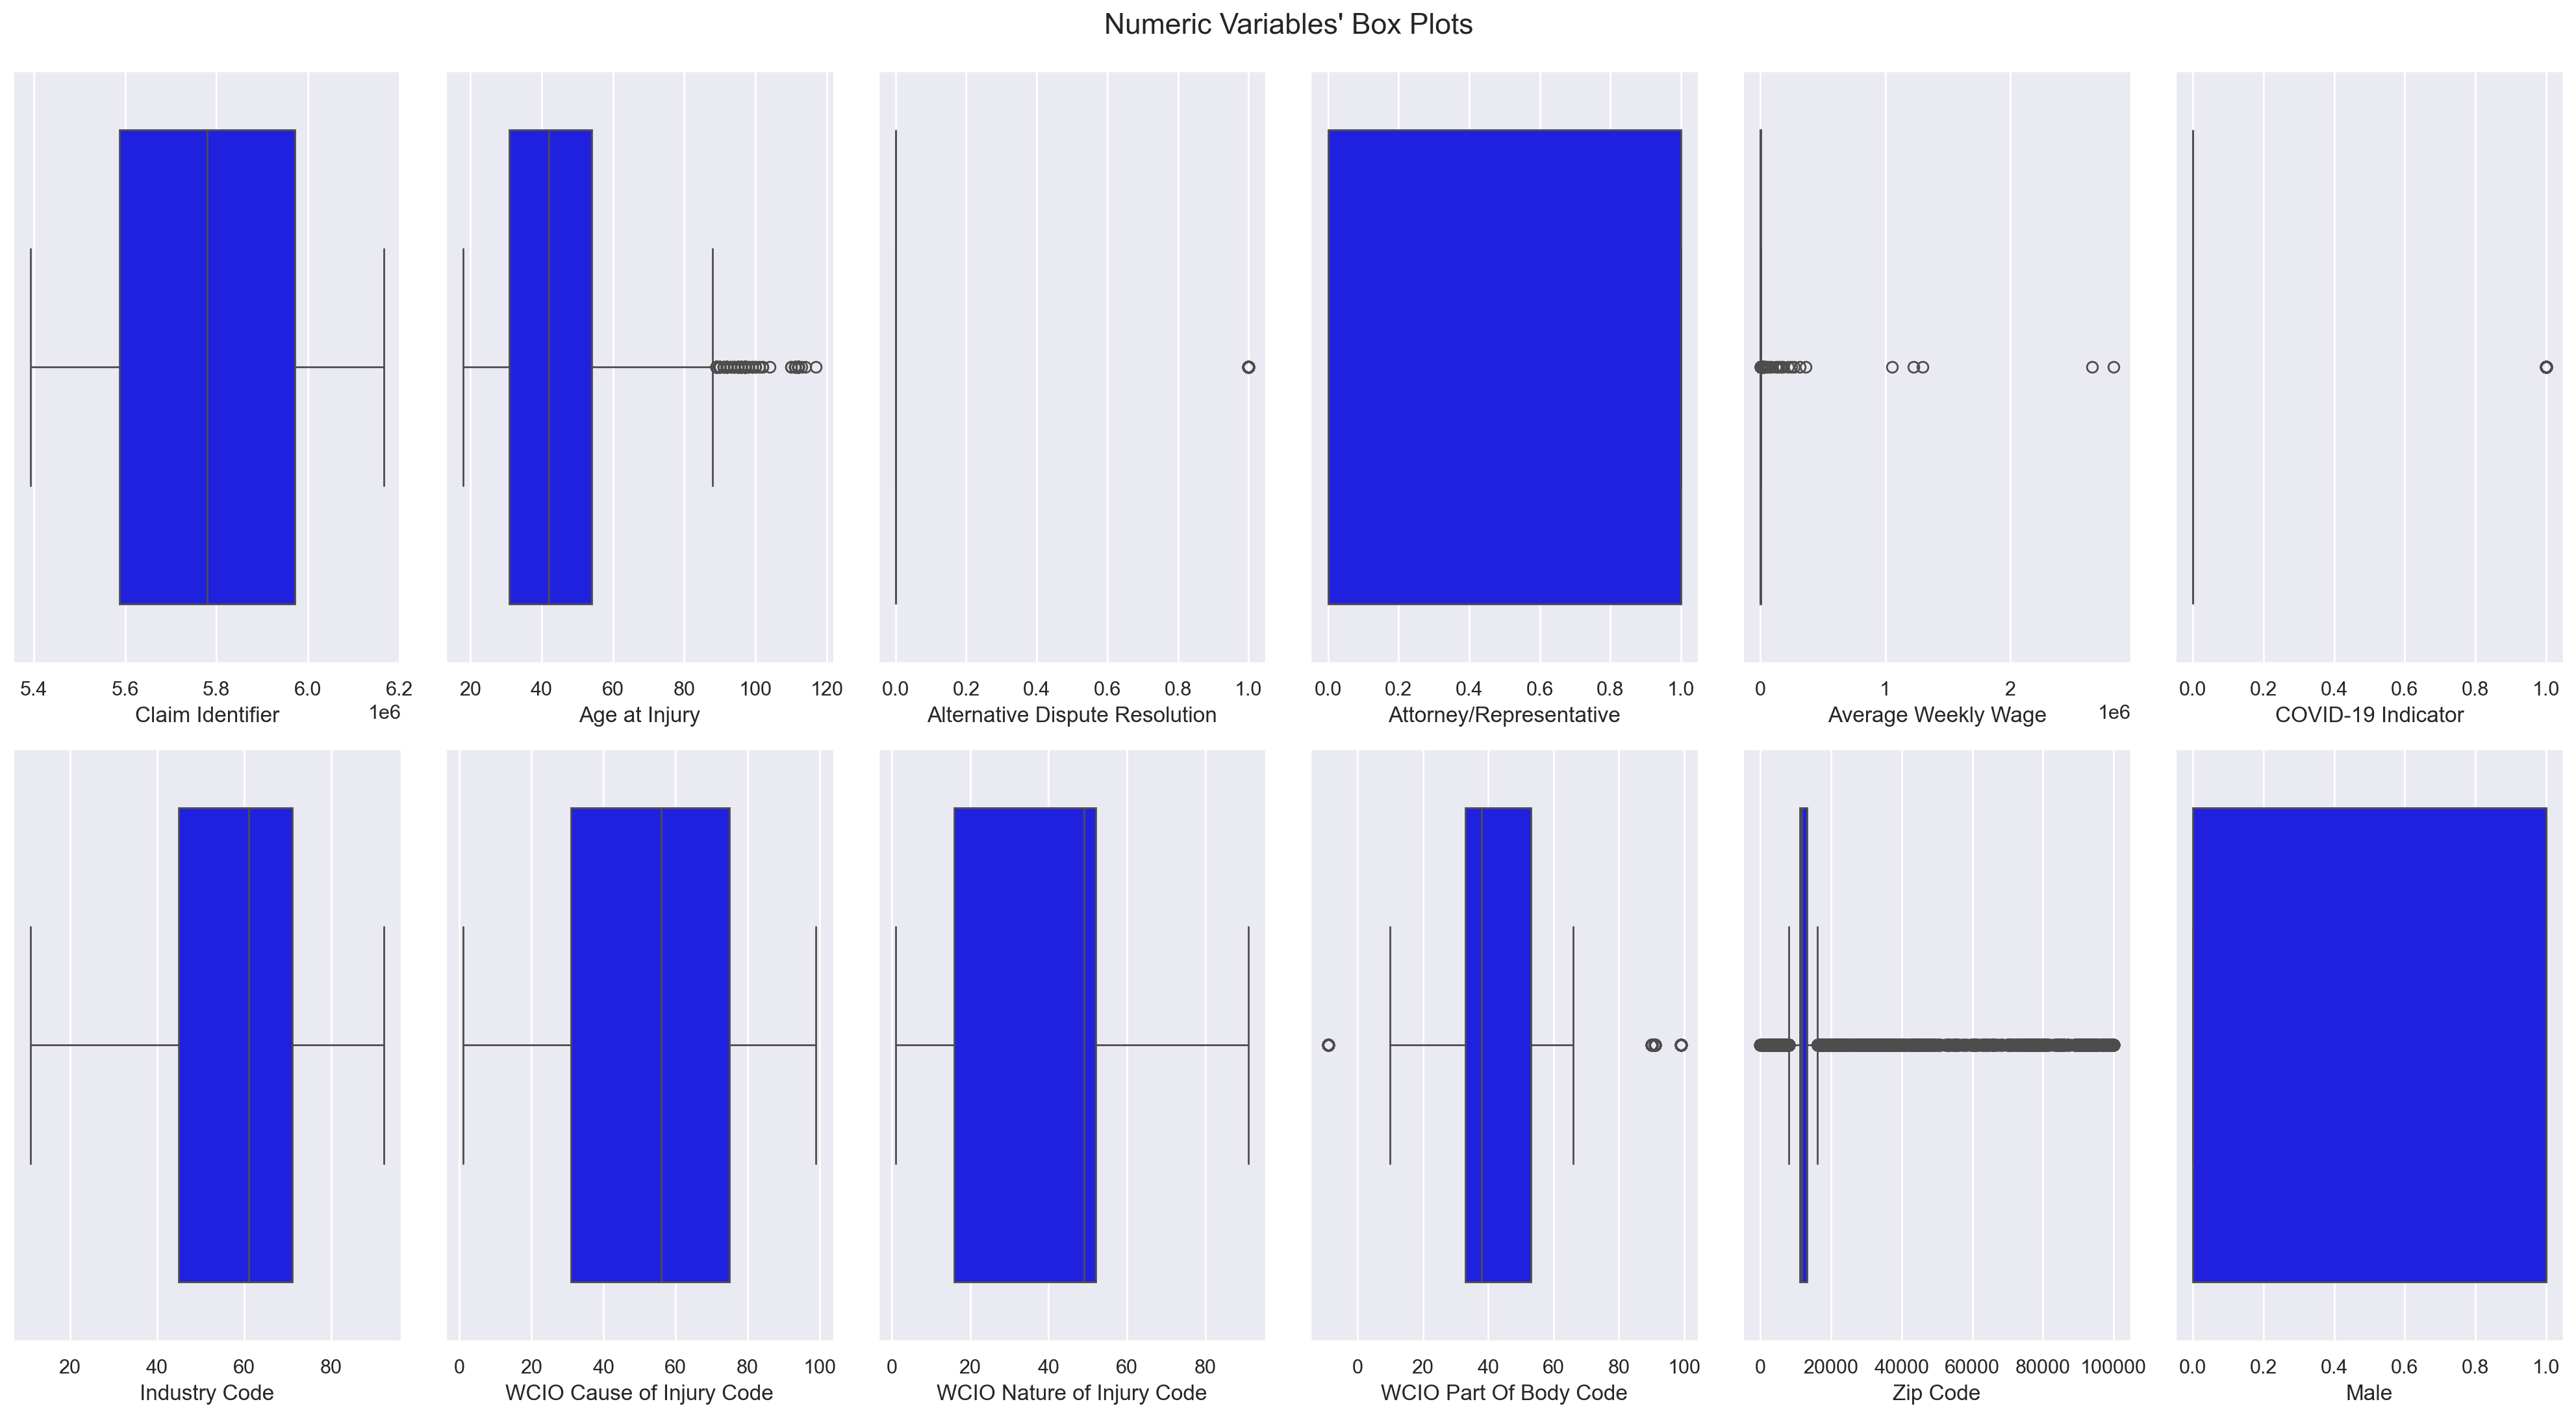

In [229]:
# Create box plots for each numerical feature
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(data=df, x=feat, ax=ax, color='blue')

plt.suptitle("Numeric Variables' Box Plots", fontsize=16, y=0.99)

# Remove empty axes (if there are any)
for ax in axes.flatten()[len(metric_features):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

### 2.1.3 Filtering <a id="filtering"></a>

#### 2.1.3.1 IQR Method <a id="iqr_method"></a>

Our initial idea was to use the **Z-score** method to identify and potentially remove outliers. However, this approach has its limitations, as it is only applicable to data columns that are normally distributed. Therefore, we decided to use the **Interquartile Range (IQR)** method to handle skewed distributions more effectively.

In [230]:
def drop_outliers_iqr(df, metric_features):
    # Calculate Q1, Q3, and IQR for each metric feature
    Q1 = df[metric_features].quantile(0.25)
    Q3 = df[metric_features].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate upper and lower bounds
    upper_lim = Q3 + 1.5 * IQR
    lower_lim = Q1 - 1.5 * IQR

    # Create a filter for rows within bounds
    filter_mask = (df[metric_features] >= lower_lim) & (df[metric_features] <= upper_lim)
    
    # Keep rows where all conditions are True across metric features
    filter_mask = filter_mask.all(axis=1)

    # Filter the original dataframe
    df_filtered = df[filter_mask]
    
    return df_filtered

In [231]:
# Usage Example
outliers_filter1 = drop_outliers_iqr(df, metric_features)

# Calculate the number of rows before and after removing outliers
original_count = len(df)
filtered_count = len(outliers_filter1)

# Calculate the percentage of rows removed
rows_removed = original_count - filtered_count
percentage_removed = (rows_removed / original_count) * 100

# Output the result
print(f'Outliers removed due to IQR method: {rows_removed} ({percentage_removed:.2f}%)')

Outliers removed due to IQR method: 197315 (35.39%)


**Conclusion:** As we can notice, this approach is problematic since it removes too much observations.

#### 2.1.3.2 Manual <a id="filter2"></a>

In [232]:
df[metric_features].describe()

,Claim Identifier,Age at Injury,Alternative Dispute Resolution,Attorney/Representative,Average Weekly Wage,COVID-19 Indicator,Industry Code,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Zip Code,Male
count,5.575230e+05,557523.00000,557521.000000,557523.000000,5.298310e+05,557523.000000,550691.000000,546491.000000,546475.000000,545325.000000,514942.000000,553068.000000
mean,5.779569e+06,42.59439,0.003724,0.311442,4.994346e+02,0.049006,58.717077,54.158385,40.894268,39.763816,12465.894788,0.585915
std,2.223205e+05,13.65551,0.060908,0.463083,6.180581e+03,0.215881,19.626000,25.740773,22.185770,22.363007,5229.213993,0.492564
min,5.393066e+06,18.00000,0.000000,0.000000,0.000000e+00,0.000000,11.000000,1.000000,1.000000,-9.000000,0.000000,0.000000
25%,5.587654e+06,31.00000,0.000000,0.000000,0.000000e+00,0.000000,45.000000,31.000000,16.000000,33.000000,11106.000000,0.000000
50%,5.779241e+06,42.00000,0.000000,0.000000,0.000000e+00,0.000000,61.000000,56.000000,49.000000,38.000000,11727.000000,1.000000
75%,5.971936e+06,54.00000,0.000000,1.000000,8.561850e+02,0.000000,71.000000,75.000000,52.000000,53.000000,13143.000000,1.000000
max,6.165685e+06,117.00000,1.000000,1.000000,2.828079e+06,1.000000,92.000000,99.000000,91.000000,99.000000,99999.000000,1.000000


In [233]:
print(sorted(df["Age at Injury"].unique(), reverse=True))

[117, 114, 113, 112, 111, 110, 104, 102, 101, 100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18]


In [234]:
# Define the threshold for age and average weekly wage
age_threshold = 100
avg_wage_threshold = 8_000 # a value 0 could be possible:
                           # the individual is a volunteer (as mention in the description)
                           # the individual might not have worked during the period,
                           # or their wage is zero for some reason (e.g., leave of absence, unemployment)

# Define conditions for each feature to identify outliers, while preserving NaN values
filter_age = df["Age at Injury"].isna() | (df["Age at Injury"] <= age_threshold)
filter_wage = df["Average Weekly Wage"].isna() | (df["Average Weekly Wage"] <= avg_wage_threshold)

# Apply the combined filter
outliers_filter2 = df[filter_age & filter_wage]

# Rows removed and percentage
rows_removed = len(df) - len(outliers_filter2)
perc_removed = (rows_removed / len(df)) * 100

# Print out the results
print(f"Outliers removed due to manual method (excluding NaNs): {rows_removed} ({round(perc_removed, 2)}%)")

Outliers removed due to manual method (excluding NaNs): 132 (0.02%)


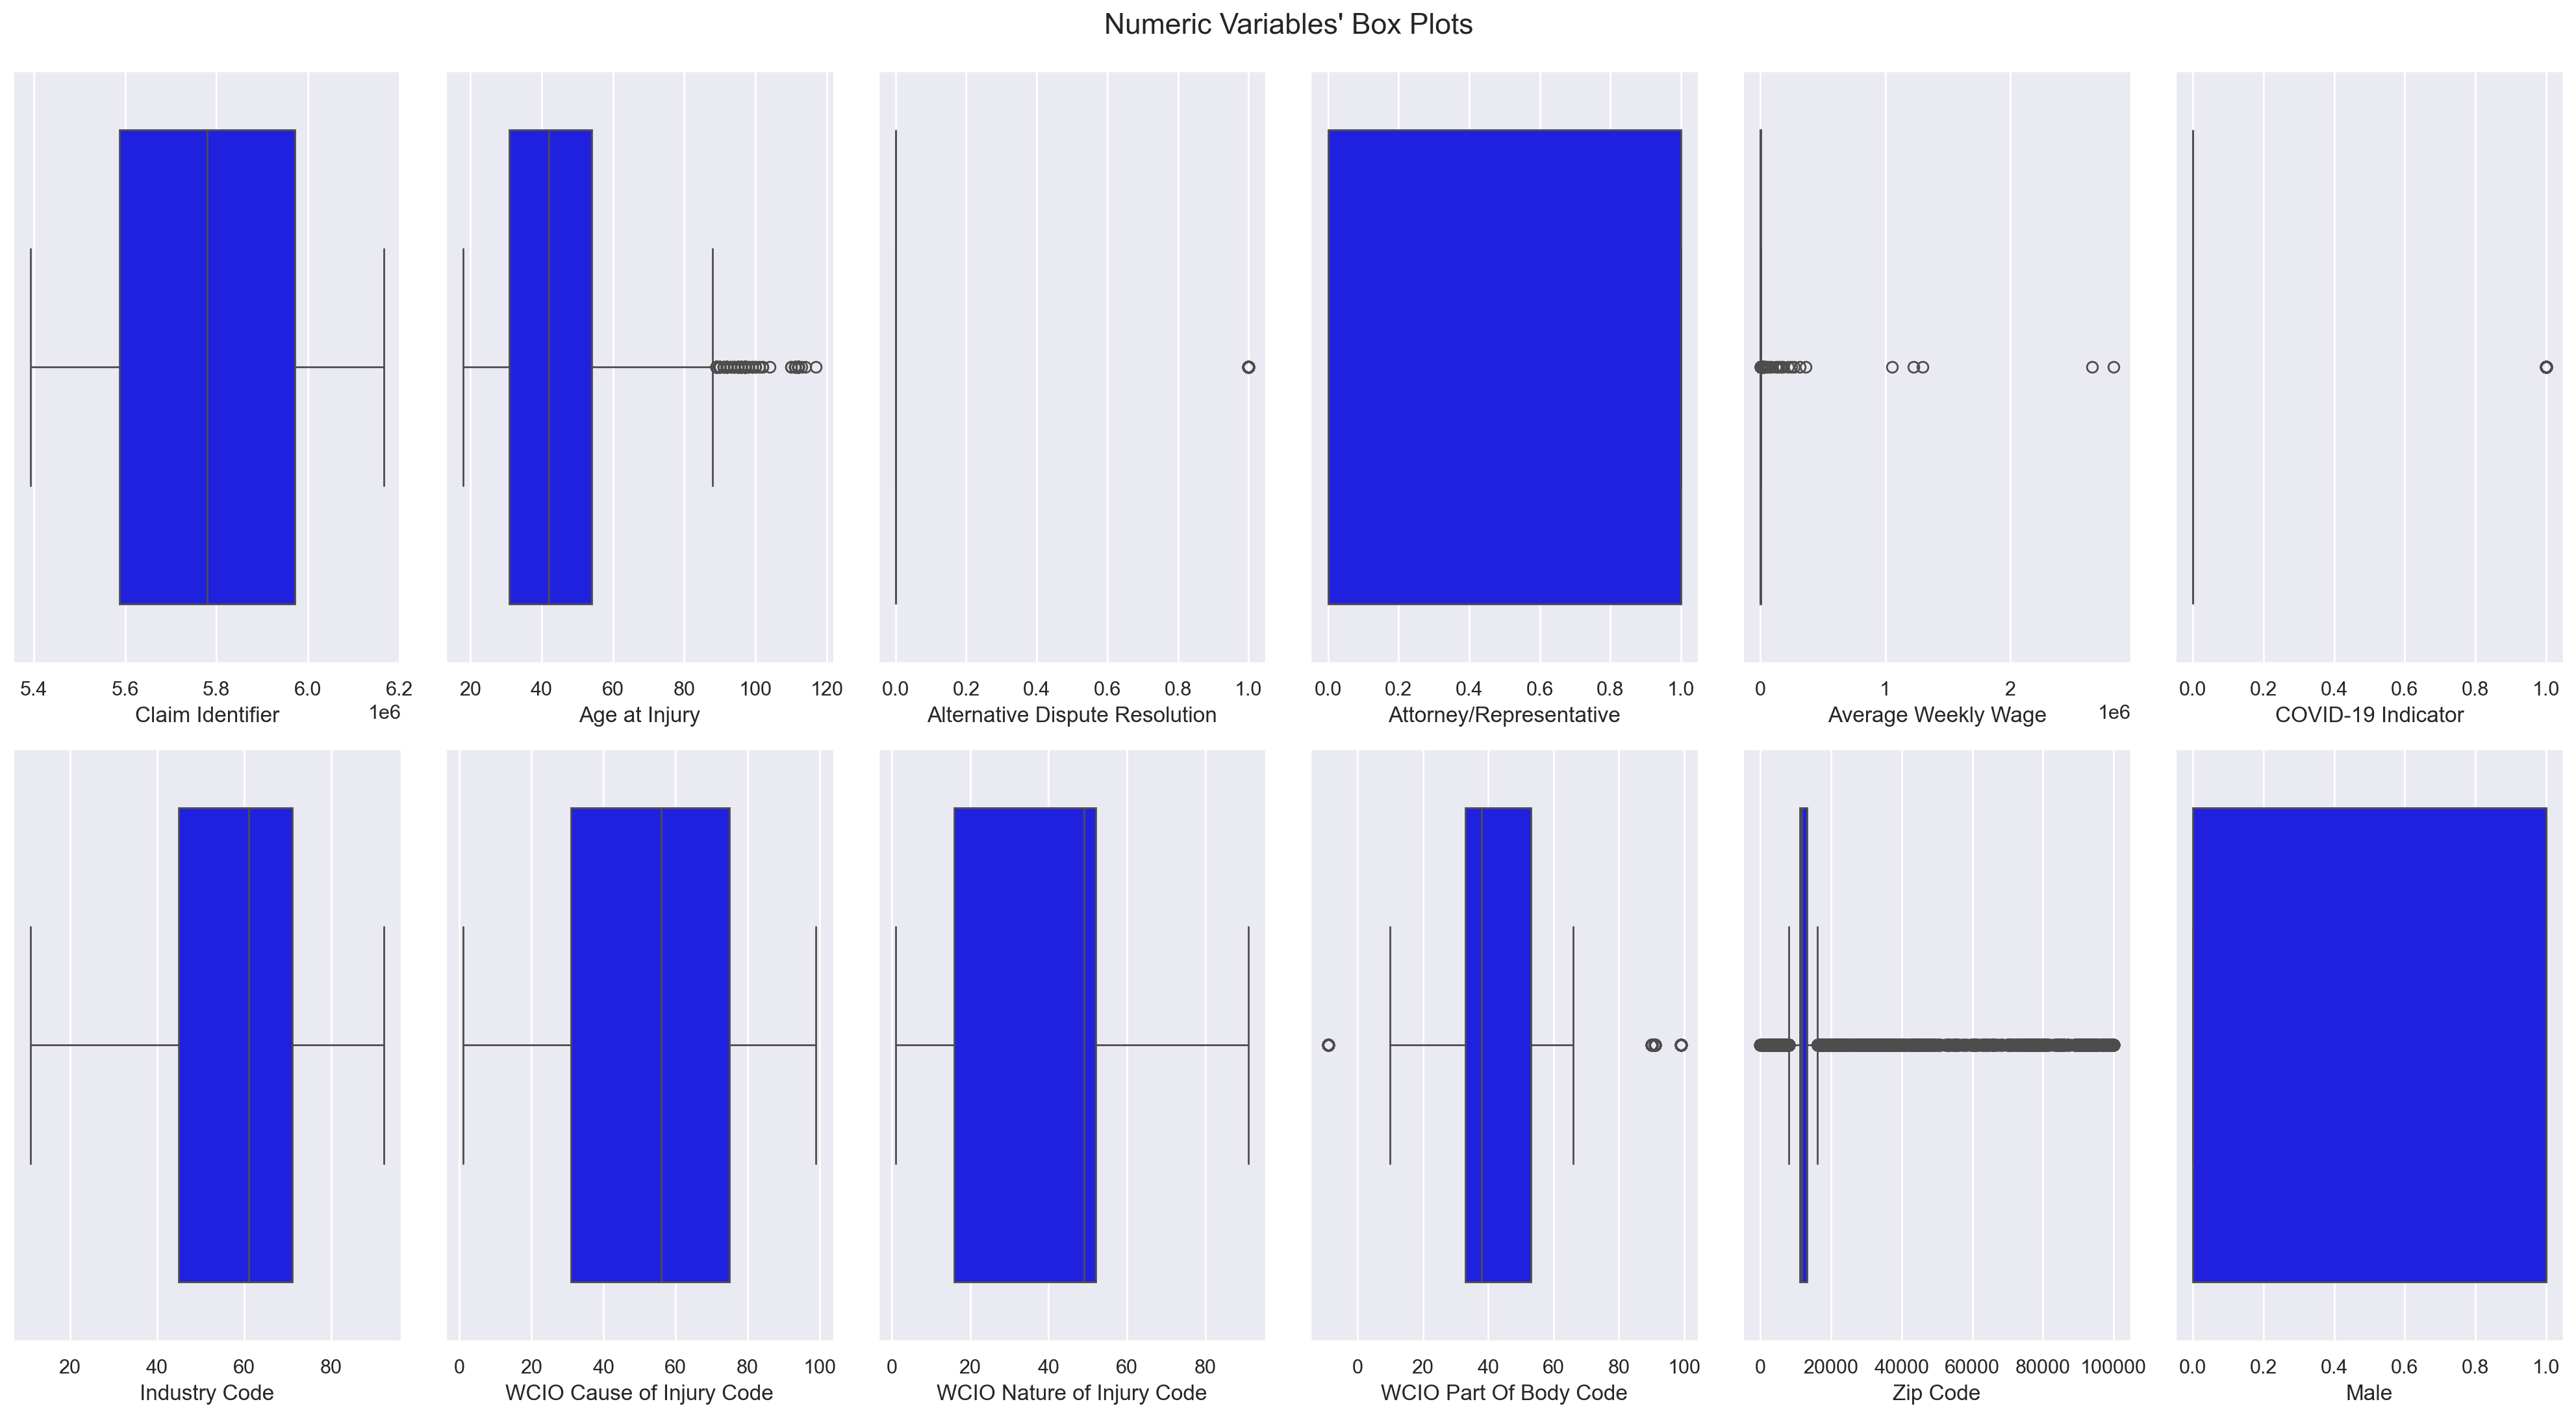

In [235]:
# Create box plots for each numerical feature
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(data=df, x=feat, ax=ax, color='blue')

plt.suptitle("Numeric Variables' Box Plots", fontsize=16, y=0.99)

# Remove empty axes (if there are any)
for ax in axes.flatten()[len(metric_features):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

#### 2.1.3.3 Winsorizing <a id="winsorizing"></a>

Winsorizing the data involves replacing the outliers with the nearest non-outlier values. This ensures that the extreme values are still accounted for in the analysis, but their impact is minimized.

In [236]:
# Define Winsorization function based on IQR
def apply_winsorization(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count affected rows before applying Winsorization
    affected_before = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]

    # Apply Winsorization
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    
    return df, affected_before

In [237]:
# Apply Winsorization to relevant columns in outliers_filter3
outliers_filter3 = df.copy()
outliers_filter3, affected_age = apply_winsorization(outliers_filter3, "Age at Injury")
outliers_filter3, affected_wage = apply_winsorization(outliers_filter3, "Average Weekly Wage")

# Calculate total affected rows and percentage for the training set
total_affected = affected_age + affected_wage
total_percentage = (total_affected / outliers_filter3.shape[0]) * 100

# Calculate individual percentages for each variable in the training set
perc_age = (affected_age / outliers_filter3.shape[0]) * 100
perc_wage = (affected_wage / outliers_filter3.shape[0]) * 100

# Print results for the training data
print(f"Age at Injury: {affected_age} outliers affected ({perc_age:.2f}%)")
print(f"Average Weekly Wage: {affected_wage} outliers affected ({perc_wage:.2f}%)")
print(f"Outliers affected due to winsorization method: {total_affected} ({total_percentage:.2f}%)")

Age at Injury: 179 outliers affected (0.03%)
Average Weekly Wage: 20581 outliers affected (3.69%)
Outliers affected due to winsorization method: 20760 (3.72%)


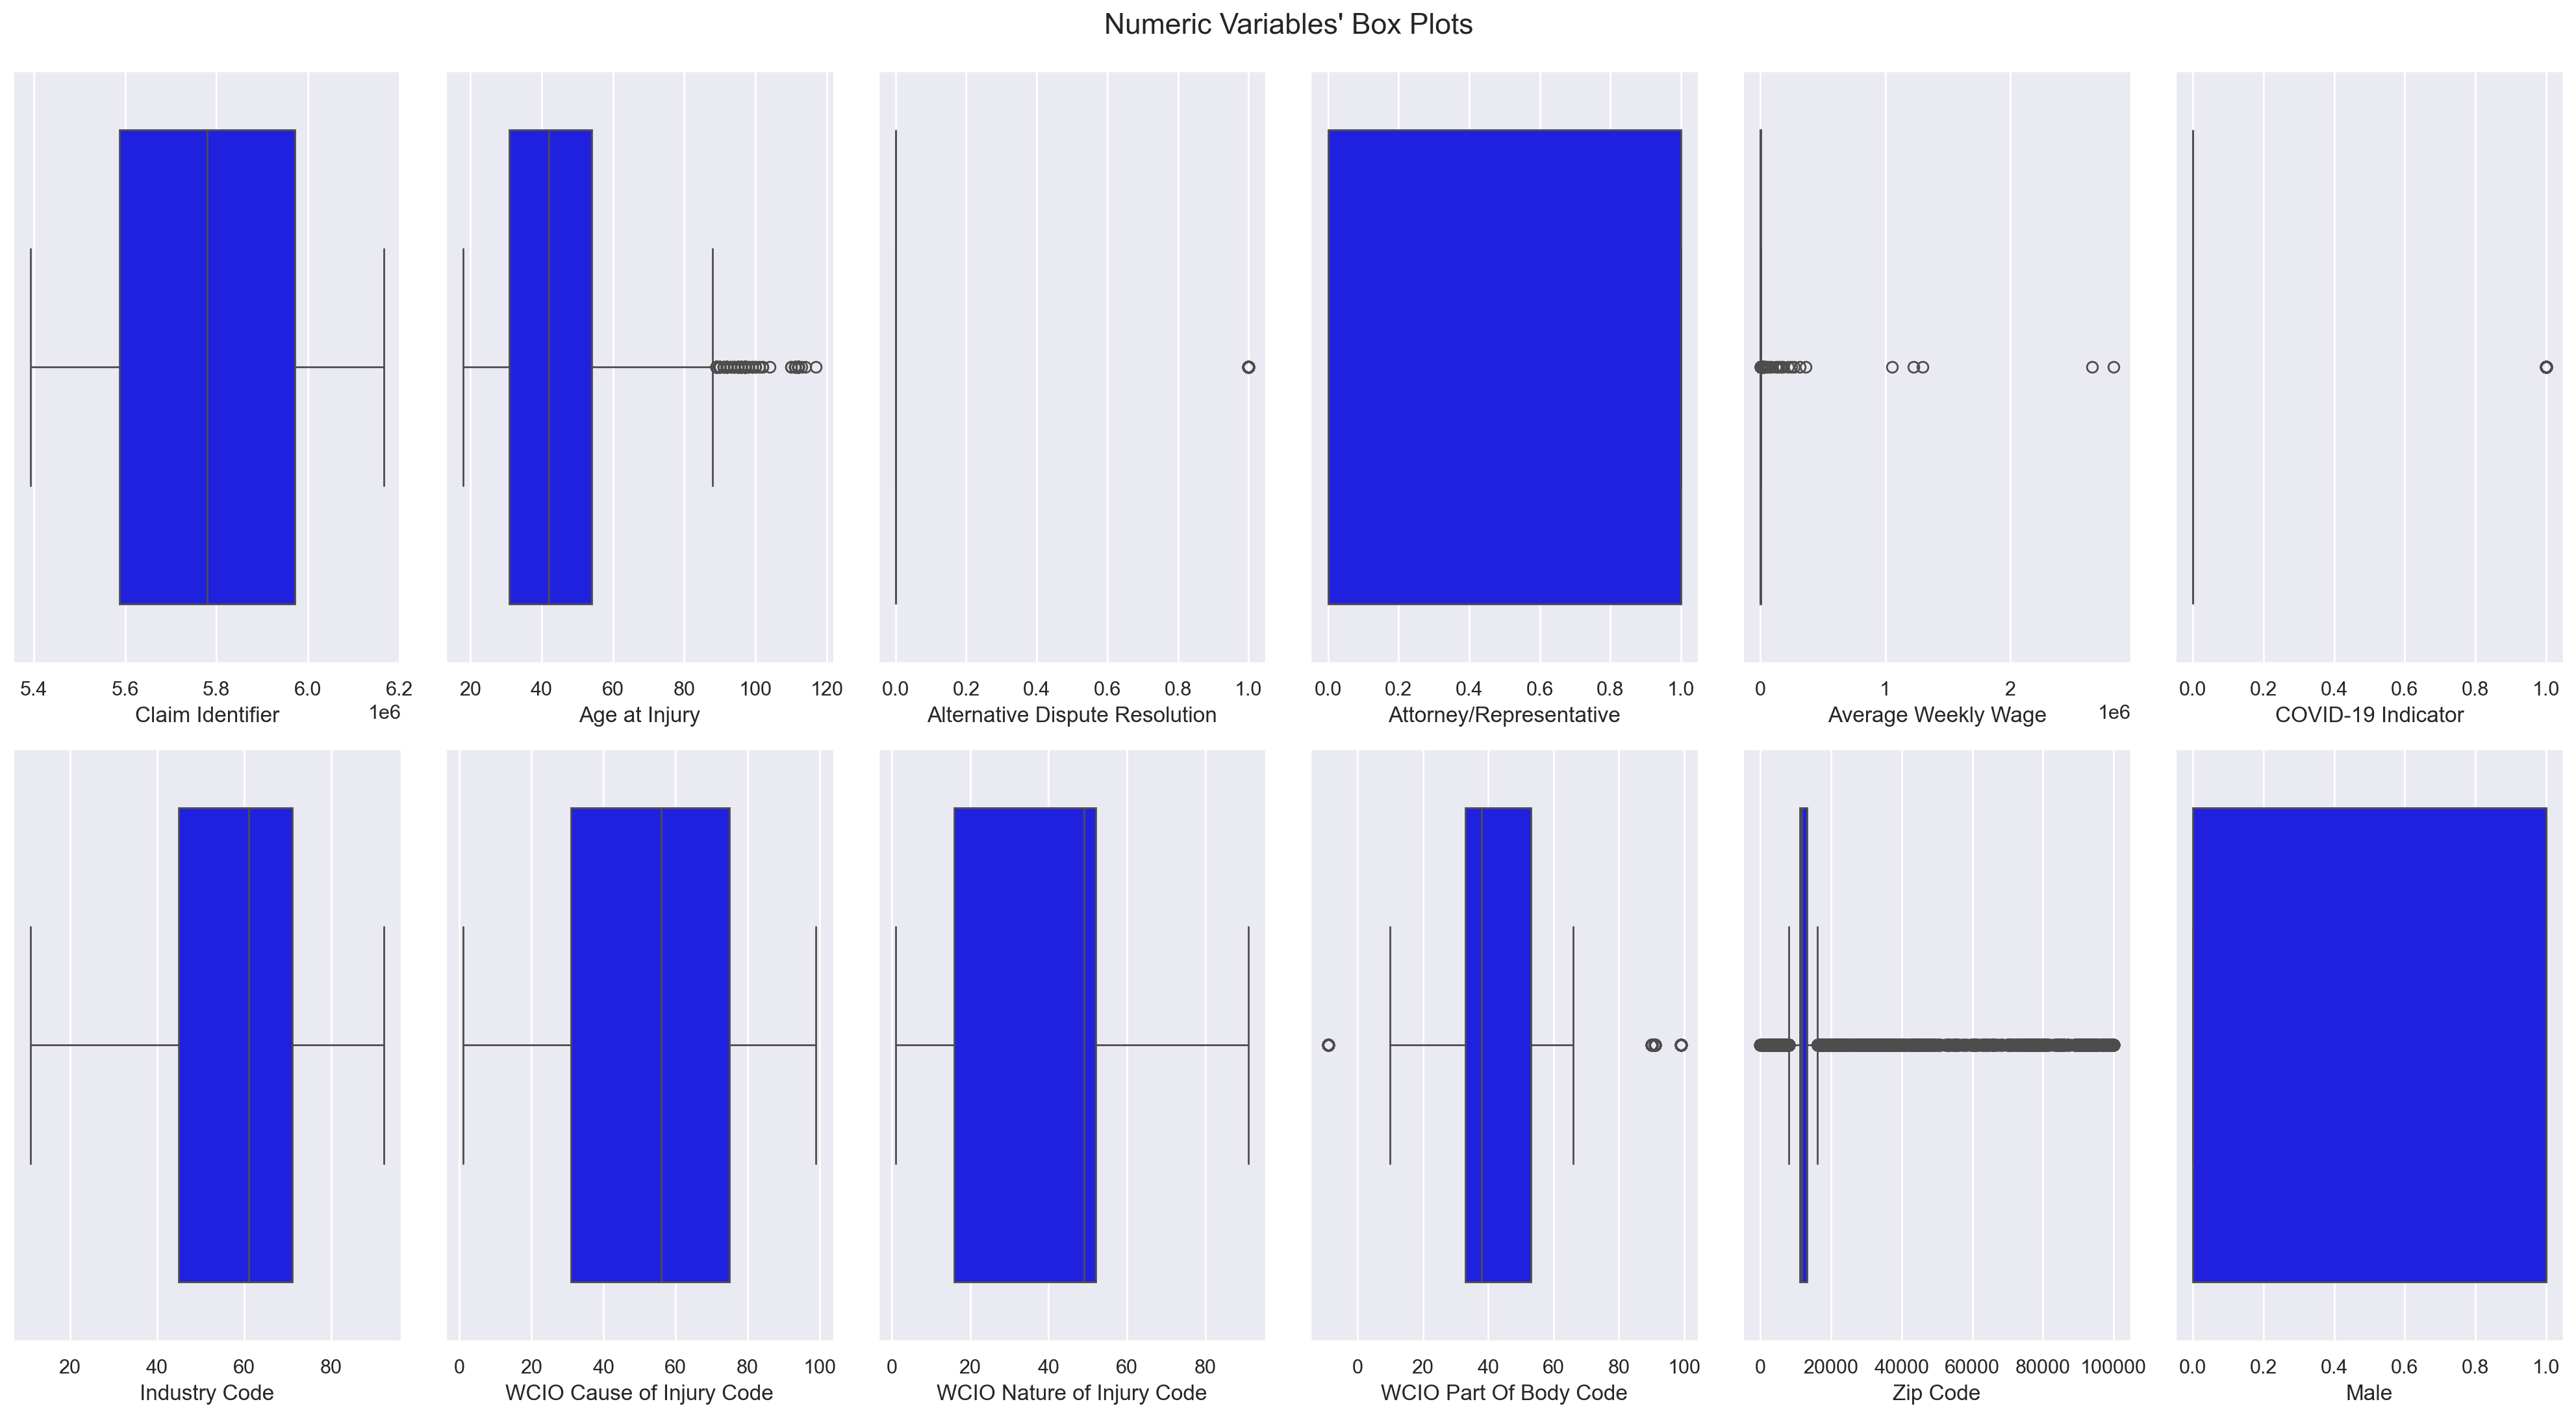

In [238]:
# Create box plots for each numerical feature
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(data=df, x=feat, ax=ax, color='blue')

plt.suptitle("Numeric Variables' Box Plots", fontsize=16, y=0.99)

# Remove empty axes (if there are any)
for ax in axes.flatten()[len(metric_features):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

## 2.2. Missing Values Imputation (Only Analysis) <a id="mv_imputation"></a>

In [239]:
# Calculate the percentage of missing values in each column
perc_missing_values = (df.isna().sum() / len(df) * 100)
perc_missing_values[perc_missing_values > 0].sort_values(ascending=False)

First Hearing Date                   73.806103
C-3 Date                             67.677387
Zip Code                              7.637532
Medical Fee Region                    5.615553
Average Weekly Wage                   4.966970
WCIO Part Of Body Code                2.187892
WCIO Part Of Body Description         2.187892
WCIO Nature of Injury Code            1.981622
WCIO Nature of Injury Description     1.981622
WCIO Cause of Injury Code             1.978752
WCIO Cause of Injury Description      1.978752
C-2 Date                              1.851583
Industry Code                         1.225420
Industry Code Description             1.225420
Male                                  0.799070
Carrier Type                          0.229766
County of Injury                      0.199454
Alternative Dispute Resolution        0.000359
dtype: float64

**Note:** For a quicker execution, we will use central tendency measures - median (for numeric features) and mode (for categorical features) to impute missing values. We might consider KNN imputation at a later stage for more accurate results.

# 3. Cross-Validation <a id="cross_validation"></a>

## 3.1 Define Auxiliary Functions <a id="aux_functions"></a>

In [240]:
# Create a dictionary of features lists
feats_dict = {
    # winsorization
    "winsorization": [
        "Age at Injury",
        "Average Weekly Wage"
    ],

    # missing values imputation
    "nums_imputation": [
        "Average Weekly Wage",
        "Male",
        "Alternative Dispute Resolution"
    ],
    "cats_imputation": [
        "Zip Code",
        "Medical Fee Region",
        "WCIO Part Of Body Code",
        "WCIO Nature of Injury Code",
        "WCIO Cause of Injury Code",
        "Industry Code",
        "Carrier Type",
        "County of Injury"
    ],
    
    # drop unnecessary columns
    "descriptions_drop": [
        "Carrier Name",
        "Industry Code Description",
        "WCIO Cause of Injury Description",
        "WCIO Nature of Injury Description",
        "WCIO Part Of Body Description"
    ],
    "dates_drop": [
        "Accident Date",
        "Assembly Date",
        "C-2 Date",
        "C-3 Date",
        "First Hearing Date"
    ],

    # categorical encoding
    "ordinal_columns": [
        "Age Group at Injury",
        "Average Weekly Wage Category"
    ],
    "high_cardinality_columns": [
        "Carrier Type",
        "County of Injury",
        "District Name",
        "Industry Code",
        "Medical Fee Region",
        "WCIO Cause of Injury Code",
        "WCIO Nature of Injury Code",
        "WCIO Part Of Body Code",
        "Zip Code",
    ],
}

In [241]:
def manual_filter_outliers(train, age_threshold=100, avg_wage_threshold=8000):
    filter_age = train["Age at Injury"].isna() | (train["Age at Injury"] <= age_threshold)
    filter_wage = train["Average Weekly Wage"].isna() | (train["Average Weekly Wage"] <= avg_wage_threshold)
    
    return train[filter_age & filter_wage]

def winsorization(train, val, col):
    # Calculate bounds based on training data
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Apply Winsorization using training bounds
    train[col] = train[col].clip(lower=lower_bound, upper=upper_bound)
    val[col] = val[col].clip(lower=lower_bound, upper=upper_bound)
    
    return train, val

def impute_missing_values(train, val, feats_dict):
    # Define numeric and categorical columns
    numeric_columns = feats_dict["nums_imputation"]
    categorical_columns = feats_dict["cats_imputation"]

    # Convert all missing values to np.nan, for consistency
    train.fillna(np.nan, inplace=True)
    val.fillna(np.nan, inplace=True)

    # Create imputers for numeric and categorical data
    numeric_imputer = SimpleImputer(strategy='median')
    categorical_imputer = SimpleImputer(strategy='most_frequent')

    # Fit imputers on training data
    train[numeric_columns] = numeric_imputer.fit_transform(train[numeric_columns])
    train[categorical_columns] = categorical_imputer.fit_transform(train[categorical_columns])

    # Apply the trained imputers to validation data
    val[numeric_columns] = numeric_imputer.transform(val[numeric_columns])
    val[categorical_columns] = categorical_imputer.transform(val[categorical_columns])

    return train, val

def create_features(df):
    # Injury Year, Quarter, and Month
    df['Injury Year'] = df['Accident Date'].dt.year
    df['Injury Quarter'] = df['Accident Date'].dt.quarter
    df['Injury Month'] = df['Accident Date'].dt.month

    # Flags for Missing Dates
    df['C-2 Date Missing'] = df['C-2 Date'].isna().astype(int)
    df['C-3 Date Missing'] = df['C-3 Date'].isna().astype(int)
    df['First Hearing Date Missing'] = df['First Hearing Date'].isna().astype(int)

    # Days Between Accident and Assembly
    df['Days Between Accident and Assembly'] = (
        (df['Assembly Date'] - df['Accident Date']).dt.days
    )

    # Age Group at Injury
    age_bins = [-float('inf'), 25, 35, 45, 60, float('inf')]
    age_labels = ['Young Adult', 'Adult', 'Mid-aged Adult', 'Older Adult', 'Senior']
    df['Age Group at Injury'] = pd.cut(df['Age at Injury'], bins=age_bins, labels=age_labels)

    # Average Weekly Wage Category
    wage_bins = [-float('inf'), 50, 300, 1000, 2000, float('inf')]
    wage_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
    df['Average Weekly Wage Category'] = pd.cut(df['Average Weekly Wage'], bins=wage_bins, labels=wage_labels)

    return df

def ordinal_encoder(X_train, X_val, feats_dict):
    # Initialize the encoder
    ordinal_encoder = OrdinalEncoder()

    for col in feats_dict["ordinal_columns"]:
        # Fit on the training data
        X_train[col] = ordinal_encoder.fit_transform(X_train[[col]])
        
        # Transform the validation data using the same encoder
        X_val[col] = ordinal_encoder.transform(X_val[[col]])
    
    return X_train, X_val

def frequency_encoder(X_train, X_val, feats_dict):

    for col in feats_dict["high_cardinality_columns"]:
        # Get frequency of each category based on training data
        freq_map = X_train[col].value_counts().to_dict()
        # Map the frequencies to the training data
        X_train[col] = X_train[col].map(freq_map)

        # Define the fill value for unseen categories in the validation data
        fill_value = X_train[col].median()
        
        # Map the frequencies to the validation data (using the training mapping)
        X_val[col] = X_val[col].map(freq_map).fillna(fill_value)


    return X_train, X_val

def scale_data(X_train, X_val, y_train, y_val):
    # Save original column names
    original_col_names = X_train.columns
    
    # Initialize the scaler
    scaler = MinMaxScaler()
    
    # Scale the numeric columns
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    
    # Convert the scaled data back to a DataFrame
    X_train = pd.DataFrame(X_train, columns=original_col_names)
    X_val = pd.DataFrame(X_val, columns=original_col_names)
    
    # Initialize the label encoder
    label_encoder = LabelEncoder()
    
    # Encode the target variable
    y_train = label_encoder.fit_transform(y_train)
    y_val = label_encoder.transform(y_val)

    # Convert the encoded labels back to a DataFrame
    y_train = pd.DataFrame(y_train, columns=['Claim Injury Type'])
    y_val = pd.DataFrame(y_val, columns=['Claim Injury Type'])
    
    return X_train, X_val, y_train, y_val

def spearman_selection(X_train, threshold=0.8):
    # Calculate the correlation matrix
    correlation_matrix = X_train.corr(method='spearman')

    # Create a set to track which features to exclude (due to high correlation)
    excluded_features = set()

    # Check for pairs of highly correlated features
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            # If the absolute correlation is above the threshold
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                feature_i = correlation_matrix.columns[i]
                feature_j = correlation_matrix.columns[j]
                # Exclude both features from the set
                excluded_features.add(feature_i)
                excluded_features.add(feature_j)
    
    # Return a list of features that are not excluded due to high correlation
    selected_features = [col for col in X_train.columns if col not in excluded_features]

    # Print the excluded features
    # print(f"Spearman Correlation - Number of Excluded Features: {len(excluded_features)} / {X_train.shape[1]}")
    # print("Spearman Correlation - Excluded Features:", excluded_features)
    # print("")
          
    return selected_features

def rfe_selection(X_train, y_train, model=None, random_state=42, fraction_to_select=0.5):
    # If no model is provided, use Logistic Regression
    if model is None:
        model = LogisticRegression(random_state=random_state)

    # Determine the number of features to select
    n_features_to_select = int(X_train.shape[1] * fraction_to_select)

    # Perform RFE
    rfe = RFE(model, n_features_to_select=n_features_to_select)
    rfe.fit(X_train, y_train)

    # Get the selected features
    selected_features = [col for col, support in zip(X_train.columns, rfe.support_) if support]

    # print(f"RFE - Number of Selected Features: {len(selected_features)} / {X_train.shape[1]}")
    # print("RFE - Selected Features:", selected_features)
    # print("")

    return selected_features

def dt_selection(X_train, y_train, random_state=42, threshold="median"):
    # Initialize Decision Tree model
    tree = DecisionTreeClassifier(random_state=random_state)
    tree.fit(X_train, y_train)

    # Get feature importances
    importance = pd.Series(tree.feature_importances_, index=X_train.columns)

    # Determine the threshold for feature selection
    if threshold == "median":
        threshold_value = np.median(importance)
    else:
        threshold_value = threshold

    # Select features above the threshold
    selected_features = list(importance[importance > threshold_value].index)

    # print(f"Decision Tree - Number of Selected Features: {len(selected_features)} / {X_train.shape[1]}")
    # print("Decision Tree - Selected Features:", selected_features)
    # print("")

    return selected_features

def lasso_selection(X_train, y_train, random_state=42):
    # Initialize Lasso Regression
    lasso = LassoCV(random_state=random_state)
    lasso.fit(X_train, y_train)

    # Extract features with non-zero coefficients
    lasso_coef = pd.Series(lasso.coef_, index=X_train.columns)
    non_zero_coef = lasso_coef[lasso_coef != 0]
    selected_features = list(non_zero_coef.index)

    # print(f"Lasso Regression - Number of Selected Features: {len(selected_features)} / {X_train.shape[1]}")
    # print("Lasso Regression - Selected Features:", selected_features)
    # print("")

    return selected_features

def voting_feature_selection(X_train, selected_features_methods, vote_threshold=None):
    # Create a DataFrame to track votes for each feature
    feature_votes = pd.DataFrame(0, index=X_train.columns, columns=selected_features_methods.keys())

    # Fill the DataFrame with votes for each feature
    for method, features in selected_features_methods.items():
        feature_votes.loc[features, method] = 1

    # Calculate total votes for each feature
    feature_votes['total_votes'] = feature_votes.sum(axis=1)

    # Define default vote threshold if not provided
    if vote_threshold is None:
        vote_threshold = len(selected_features_methods) // 2  # Majority rule

    # Select features based on vote threshold
    final_selected_features = feature_votes[feature_votes['total_votes'] > vote_threshold].index.tolist()

    # print(f"Majority Voting - Number of Selected Features: {len(final_selected_features)} / {X_train.shape[1]}")
    # print("Majority Voting - Selected Features:", final_selected_features)
    # print("")

    return final_selected_features

## 3.2 Define Cross-Validation Function <a id="cv_function"></a>

In [242]:
# Define function to perform cross-validation
def cross_validation(model, param_grid, df, feats_dict, n_splits=5, n_repeats=2):
    # Separate features and target
    X = df.drop(columns=["Claim Injury Type"])
    y = df["Claim Injury Type"]

    # Initialize lists to store F1 scores
    f1_train_list = []
    f1_val_list = []
    time_list = []
    n_iter_list = []
    best_params_list = []

    # Cross-validation strategy
    rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

    # Perform cross-validation
    for iter, (train_index, val_index) in enumerate(rskf.split(X, y)):
        # Split data 
        X_train, X_val = X.iloc[train_index].copy(), X.iloc[val_index].copy()
        y_train, y_val = y.iloc[train_index].copy(), y.iloc[val_index].copy()

        # Apply manual outlier removal
        X_train = manual_filter_outliers(X_train)
        y_train = y_train.loc[X_train.index]
        
        # Winsorization
        for col in feats_dict["winsorization"]:
            X_train, X_val = winsorization(X_train, X_val, col)

        # Missing values imputation
        X_train, X_val = impute_missing_values(X_train, X_val, feats_dict)

        # Feature engineering
        X_train = create_features(X_train)
        X_val = create_features(X_val)

        # Drop description and date columns
        X_train.drop(columns = feats_dict["descriptions_drop"] + feats_dict["dates_drop"], inplace=True)
        X_val.drop(columns = feats_dict["descriptions_drop"] + feats_dict["dates_drop"], inplace=True)

        # Ordinal and frequency encoding
        X_train, X_val = ordinal_encoder(X_train, X_val, feats_dict)
        X_train, X_val = frequency_encoder(X_train, X_val, feats_dict)

        # Scale data
        X_train, X_val, y_train, y_val = scale_data(X_train, X_val, y_train, y_val)
    
        # Feature selection
        selected_feats_spearman = spearman_selection(X_train)
        selected_feats_rfe = rfe_selection(X_train, y_train)
        selected_feats_dt = dt_selection(X_train, y_train)
        selected_feats_lasso = lasso_selection(X_train, y_train)

        selected_features_methods = {
            'spearman': selected_feats_spearman,
            'rfe': selected_feats_rfe,
            'dt': selected_feats_dt,
            'lasso': selected_feats_lasso,
        }
        final_selected_features = voting_feature_selection(X_train, selected_features_methods)
        X_train = X_train[final_selected_features]
        X_val = X_val[final_selected_features]

        # Model with GridSearchCV
        gridsearch = GridSearchCV(estimator=model, param_grid=param_grid, scoring="f1", cv=3)

        # Time the model training
        begin = time.perf_counter()
        gridsearch.fit(X_train, y_train)
        end = time.perf_counter()

        # Collect metrics
        time_list.append(end - begin)
        best_params_list.append(gridsearch.best_params_)
        best_lr = gridsearch.best_estimator_
        y_train_pred_lr = best_lr.predict(X_train)
        y_val_pred_lr = best_lr.predict(X_val)
        f1_train_list.append(f1_score(y_train, y_train_pred_lr, average="weighted"))
        f1_val_list.append(f1_score(y_val, y_val_pred_lr, average="weighted"))
        n_iter = getattr(best_lr, "n_iter_", [[0]])
        n_iter_list.append(n_iter[0] if isinstance(n_iter, list) else n_iter)

        # Print results
        print(f"CV Iter {iter + 1}: "
              f"F1 Train = {f1_train_list[-1]:.3f}, " 
              f"F1 Val = {f1_val_list[-1]:.3f}, "
              f"Time (s) = {time_list[-1]:.2f}, "
              f"Avg Iter = {np.mean(n_iter_list[-1]):.1f}")

    # Return the final metrics
    return f1_train_list, f1_val_list, time_list, n_iter_list, best_params_list

## 3.3 Define Function to Show Cross-Validation Results <a id="show_results_function"></a>

In [243]:
# Define function to show results
def show_results(model, param_grid, df, feats_dict):
    # Perform cross-validation for the current model
    f1_train_list, f1_val_list, time_list, n_iter_list, best_params_list = cross_validation(
        model,
        param_grid,
        df,
        feats_dict,
    )

    # Compute average and standard deviation for each metric
    avg_train = f"{np.mean(f1_train_list):.3f} +/- {np.std(f1_train_list):.2f}"
    avg_val = f"{np.mean(f1_val_list):.3f} +/- {np.std(f1_val_list):.2f}"
    avg_time = f"{np.mean(time_list):.3f} +/- {np.std(time_list):.2f}"
    flattened_n_iter = [item for sublist in n_iter_list for item in sublist] # Flatten the n_iter_list (list of lists)
    avg_iter = f"{np.mean(flattened_n_iter):.1f} +/- {np.std(flattened_n_iter):.1f}" 

    # Determine the mode of best parameters

    # Convert the list of dictionaries to a DataFrame
    best_params_df = pd.DataFrame(best_params_list)
    # Find the mode of parameter combinations
    best_params_mode = best_params_df.apply(lambda row: tuple(sorted(row.items())), axis=1).value_counts().idxmax()
    # Convert the tuple back to a dictionary
    best_params_mode = dict(best_params_mode)

    # Create an empty DataFrame to store the results
    results = pd.DataFrame(columns=["Train F1", "Validation F1", "Time (s)", "Iterations", "Best Params Mode"])

    # Append results to the DataFrame, with model name as the index
    results.loc[model] = [avg_train, avg_val, avg_time, avg_iter, best_params_mode]
    
    return results

## 3.4 Apply Cross-Validation <a id="apply_cv"></a>

**Logistic Regression**
- A simple, interpretable model ideal for linear relationships in multi-class problems.
- https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html

In [ ]:
# Define parameters grid
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'solver': ['liblinear', 'lbfgs'],
    'class_weight': ['balanced', None], # The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data
}

# # Sample 1000 observations from the dataset
# df_sample = df.sample(n=1000, random_state=42)

# # If you want to reset the index after sampling (optional)
# df_sample.reset_index(drop=True, inplace=True)

# Show the results
lr_results = show_results(LogisticRegression(), param_grid, df, feats_dict)
lr_results

CV Iter 1: F1 Train = 0.616, F1 Val = 0.579, Time (s) = 0.28, Avg Iter = 5.7
CV Iter 2: F1 Train = 0.614, F1 Val = 0.560, Time (s) = 0.27, Avg Iter = 5.5
CV Iter 3: F1 Train = 0.613, F1 Val = 0.616, Time (s) = 0.27, Avg Iter = 5.7
CV Iter 4: F1 Train = 0.604, F1 Val = 0.576, Time (s) = 0.29, Avg Iter = 6.0
CV Iter 5: F1 Train = 0.615, F1 Val = 0.599, Time (s) = 0.27, Avg Iter = 5.7
CV Iter 6: F1 Train = 0.623, F1 Val = 0.614, Time (s) = 0.31, Avg Iter = 5.5
CV Iter 7: F1 Train = 0.611, F1 Val = 0.598, Time (s) = 0.26, Avg Iter = 5.5
CV Iter 8: F1 Train = 0.610, F1 Val = 0.593, Time (s) = 0.24, Avg Iter = 5.3
CV Iter 9: F1 Train = 0.627, F1 Val = 0.613, Time (s) = 0.25, Avg Iter = 5.5
CV Iter 10: F1 Train = 0.629, F1 Val = 0.578, Time (s) = 0.25, Avg Iter = 5.7


,Train F1,Validation F1,Time (s),Iterations,Best Params Mode
LogisticRegression(),0.616 +/- 0.01,0.593 +/- 0.02,0.269 +/- 0.02,5.6 +/- 0.9,"{'C': 0.1, 'class_weight': 'balanced', 'solver..."


**Random Forest**
- An ensemble method that enhances accuracy, handles numerous features, and reduces overfitting.
- https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestClassifier.html

**XGBoost**
- A powerful model that builds trees sequentially to improve accuracy, excelling with structured data.
- https://xgboost.readthedocs.io/en/stable/parameter.html

**Support Vector Machine**
- **Note:** takes a lot of time to run
- https://scikit-learn.org/1.5/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC